<a href="https://colab.research.google.com/github/prayas99/AnomalyDetection/blob/master/xor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
np.random.seed(0)
data = 2*np.random.uniform(size=(10000,2))-1

In [ ]:
data.shape

(10000, 2)

In [ ]:
data[0]

array([0.09762701, 0.43037873])

In [ ]:
y = []
y = [1 if x[0]*x[1]<0 else 0 for x in data]
#y = np.reshape(y,(10000,1))
#y.shape
df2 = pd.DataFrame(
    data, columns=['x1','x2']
)
df2['y'] = y
display(df2)
# df = pd.DataFrame({
#     'x1':data[0],
#     'x2':data[1],
#     'y':y
# })
# df.head()

,x1,x2,y
0,0.097627,0.430379,0
1,0.205527,0.089766,0
2,-0.152690,0.291788,1
3,-0.124826,0.783546,1
4,0.927326,-0.233117,1
...,...,...,...
9995,0.073616,0.057428,0
9996,0.213897,0.410607,0
9997,0.907101,0.496349,0
9998,-0.403467,-0.107088,0


In [ ]:
import torch
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
class CustomDatasetFromCSV(Dataset):
    def __init__(self, data, transform=None):
        self.data = data #torch.FloatTensor(data.values.astype('float'))
        self.transforms = transforms
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, index):
        # This method should return only 1 sample and label 
        # (according to "index"), not the whole dataset
        # So probably something like this for you:
        target = self.data.iloc[index,-1]
        data_val = self.data.iloc[index,:-1]
        target = torch.tensor(target)
        data_val = torch.tensor(data_val,dtype=torch.float32) 
        return data_val,target

    def __len__(self):
        return len(self.data)


dataset = CustomDatasetFromCSV(df2)
batch_size = 16
validation_split = .15
test_split = .15
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
split = int(np.floor((validation_split+test_split) * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[split:], indices[:split//2], indices[split//2:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler,drop_last=True)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler,drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                                sampler=test_sampler,drop_last=True)

10000


In [ ]:
class mymodel(torch.nn.Module):
    def __init__(self, D_in, H=4, D_out=2):
        """
        In the constructor we construct three nn.Linear instances that we will use
        in the forward pass.
        """
        super(mymodel, self).__init__()
        self.input_linear = torch.nn.Linear(D_in, H)
        self.output_linear = torch.nn.Linear(H, D_out)

    def forward(self, x):
            # Max pooling over a (2, 2) window
            x = F.relu(self.input_linear(x))
            x = self.output_linear(x)
            return x

In [ ]:
print(len(train_loader))
print(len(validation_loader))
print(len(test_loader))

437
93
93


In [ ]:
D_in = 2; H = 4; D_out = 2
model = mymodel(D_in, H, D_out)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
if torch.cuda.is_available():
    model.to('cuda')
# Initialize steps
step = 0
epochs=100
train_loss_list = []
valid_loss_list = []
train_acc_l = []
val_acc_l = []
# Iterate over number of epochs
for e in range(epochs):
    running_loss_train = 0 
    running_loss_valid = 0
    validation_correct = 0
    validation_total = 0

    training_correct = 0
    training_total = 0  
                  
    

    # Iterate over the entire training dataset
    # one batch per iteration 
    for inputs, labels in train_loader:

        # Clear the gradients of all optimized tensors
        optimizer.zero_grad()
        if torch.cuda.is_available():
            inputs, labels = inputs.to('cuda'), labels.to('cuda')   
        else:
            inputs, labels = input_images, labels        
        # Forward pass
        model.train()
        outputs = model.forward(inputs)
        _, predicted = torch.max(outputs.data, 1)
        #print(predicted,labels)
    
        #print(predicted,labels)

        training_total += labels.size(0)
        training_correct += (predicted == labels).sum().item() 
        #no_grad() prevents tracking history (and using memory)
        # with torch.no_grad(): 
            
        #     # Iterate over the entire validation dataset
        #     for input_images3, labels3 in train_loader:
                
        #         # Enable CUDA: use GPUs for model computation
        #         if torch.cuda.is_available():
        #             input_images3, labels3 = input_images3.to('cuda'), labels3.to('cuda')
                
        #         # Make predictions 
        #         outputs3 = model(input_images3)
        #         #print(outputs3)
        #         _, predicted3 = torch.max(outputs3.data, 1)
        #         #print(predicted2,labels2)
                
        #         # Count total and correct predictions
  

        
        train_loss = criterion(outputs, labels)
        
        train_acc = training_correct / training_total
        # Backward pass
        train_loss.backward()
        optimizer.step()
        
        # Calculate and print running training loss
        running_loss_train += train_loss.item()   
        
    with torch.no_grad():    
            #count=0         
            # Iterate over the entire validation dataset
            for input_images2, labels2 in validation_loader:
                
                # Enable CUDA: use GPUs for model computation
                #count+=1
                #print(count)
                if torch.cuda.is_available():
                    input_images2, labels2 = input_images2.to('cuda'), labels2.to('cuda')
                
                # Make predictions 
                outputs2 = model.forward(input_images2)
                _, predicted2 = torch.max(outputs2.data, 1)
                #print(predicted2,labels2)
                
                # Count total and correct predictions
                validation_total += labels2.size(0)
                validation_correct += (predicted2 == labels2).sum().item()   
                valid_loss = criterion(outputs2, labels2)
                val_acc = validation_correct / validation_total
                running_loss_valid += valid_loss.item()  
    
    print("Epoch: {}/{}... ".format(e+1, epochs),
          "| Train Loss: {:.4f}".format(running_loss_train/len(train_loader)),
          "| Val Loss: {:.4f}".format(running_loss_valid/len(validation_loader)),
          "| Train Acc: {:.4f}".format(train_acc),
          "| Val Acc: {:.4f}".format(val_acc))
    train_loss_list.append(running_loss_train/len(train_loader))
    valid_loss_list.append(running_loss_valid/len(validation_loader))
    train_acc_l.append(train_acc)
    val_acc_l.append(val_acc)
          
    running_loss_train = 0
    running_loss_valid = 0

Epoch: 1/100...  | Train Loss: 0.7000 | Val Loss: 0.6966 | Train Acc: 0.5001 | Val Acc: 0.5054
Epoch: 2/100...  | Train Loss: 0.6957 | Val Loss: 0.6928 | Train Acc: 0.4999 | Val Acc: 0.5047
Epoch: 3/100...  | Train Loss: 0.6921 | Val Loss: 0.6895 | Train Acc: 0.5113 | Val Acc: 0.5370
Epoch: 4/100...  | Train Loss: 0.6889 | Val Loss: 0.6863 | Train Acc: 0.4874 | Val Acc: 0.4630
Epoch: 5/100...  | Train Loss: 0.6860 | Val Loss: 0.6835 | Train Acc: 0.3927 | Val Acc: 0.3999
Epoch: 6/100...  | Train Loss: 0.6833 | Val Loss: 0.6806 | Train Acc: 0.4492 | Val Acc: 0.4671
Epoch: 7/100...  | Train Loss: 0.6807 | Val Loss: 0.6776 | Train Acc: 0.4990 | Val Acc: 0.5074
Epoch: 8/100...  | Train Loss: 0.6782 | Val Loss: 0.6750 | Train Acc: 0.5290 | Val Acc: 0.5249
Epoch: 9/100...  | Train Loss: 0.6758 | Val Loss: 0.6728 | Train Acc: 0.5409 | Val Acc: 0.5430
Epoch: 10/100...  | Train Loss: 0.6733 | Val Loss: 0.6698 | Train Acc: 0.5536 | Val Acc: 0.5578
Epoch: 11/100...  | Train Loss: 0.6710 | Val Loss

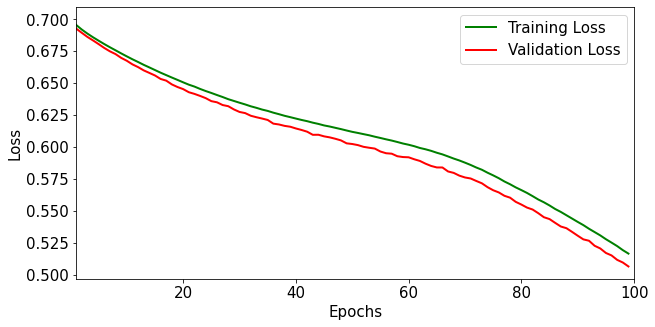

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
# train_loss_list2 = [x/len(train_loader) for x in train_loss_list]
# valid_loss_list2 = [x/len(validation_loader) for x in valid_loss_list]
plt.plot(train_loss_list,c='g',label="Training Loss",linewidth=2)
plt.plot(valid_loss_list,c='r',label="Validation Loss",linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(1,100)
plt.legend()
plt.show()

In [ ]:
print(len(train_acc_l))

100


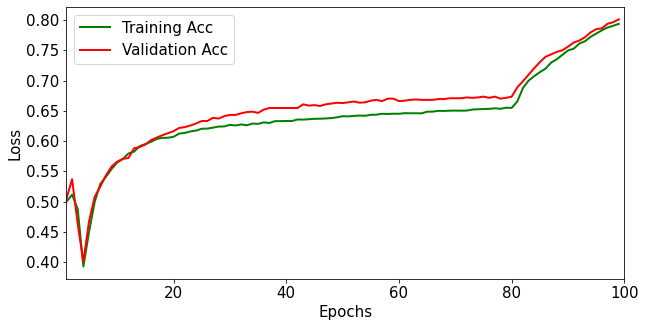

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,5))
# train_loss_list2 = [x/len(train_loader) for x in train_loss_list]
# valid_loss_list2 = [x/len(validation_loader) for x in valid_loss_list]
plt.plot(train_acc_l,c='g',label="Training Acc",linewidth=2)
plt.plot(val_acc_l,c='r',label="Validation Acc",linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(1,100)
plt.legend()
plt.show()

In [ ]:
H_list = [2,4,6,8,10]
dict_trainL = {}
dict_valL = {}
dict_trainAcc={}
dict_valAcc={}

for H in H_list:
    D_in = 2; H = H; D_out = 2
    model = mymodel(D_in, H, D_out)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
    if torch.cuda.is_available():
        model.to('cuda')
    # Initialize steps
    step = 0
    epochs = 20
    train_loss_list = []
    valid_loss_list = []
    train_acc_l = []
    val_acc_l = []
    # Iterate over number of epochs
    for e in range(epochs):
        running_loss_train = 0 
        running_loss_valid = 0
        validation_correct = 0
        validation_total = 0

        training_correct = 0
        training_total = 0  
                      
        

        # Iterate over the entire training dataset
        # one batch per iteration 
        for inputs, labels in train_loader:

            # Clear the gradients of all optimized tensors
            optimizer.zero_grad()
            if torch.cuda.is_available():
                inputs, labels = inputs.to('cuda'), labels.to('cuda')   
            else:
                inputs, labels = input_images, labels        
            # Forward pass
            model.train()
            outputs = model.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,labels)
        
            #print(predicted,labels)

            training_total += labels.size(0)
            training_correct += (predicted == labels).sum().item() 
            #no_grad() prevents tracking history (and using memory)
            # with torch.no_grad(): 
                
            #     # Iterate over the entire validation dataset
            #     for input_images3, labels3 in train_loader:
                    
            #         # Enable CUDA: use GPUs for model computation
            #         if torch.cuda.is_available():
            #             input_images3, labels3 = input_images3.to('cuda'), labels3.to('cuda')
                    
            #         # Make predictions 
            #         outputs3 = model(input_images3)
            #         #print(outputs3)
            #         _, predicted3 = torch.max(outputs3.data, 1)
            #         #print(predicted2,labels2)
                    
            #         # Count total and correct predictions
      

            
            train_loss = criterion(outputs, labels)
            
            train_acc = training_correct / training_total
            # Backward pass
            train_loss.backward()
            optimizer.step()
            
            # Calculate and print running training loss
            running_loss_train += train_loss.item()   
            
        with torch.no_grad():    
                #count=0         
                # Iterate over the entire validation dataset
                for input_images2, labels2 in validation_loader:
                    
                    # Enable CUDA: use GPUs for model computation
                    #count+=1
                    #print(count)
                    if torch.cuda.is_available():
                        input_images2, labels2 = input_images2.to('cuda'), labels2.to('cuda')
                    
                    # Make predictions 
                    outputs2 = model.forward(input_images2)
                    _, predicted2 = torch.max(outputs2.data, 1)
                    #print(predicted2,labels2)
                    
                    # Count total and correct predictions
                    validation_total += labels2.size(0)
                    validation_correct += (predicted2 == labels2).sum().item()   
                    valid_loss = criterion(outputs2, labels2)
                    val_acc = validation_correct / validation_total
                    running_loss_valid += valid_loss.item()  
        
        print("Epoch: {}/{}... ".format(e+1, epochs),
              "| Train Loss: {:.4f}".format(running_loss_train/len(train_loader)),
              "| Val Loss: {:.4f}".format(running_loss_valid/len(validation_loader)),
              "| Train Acc: {:.4f}".format(train_acc),
              "| Val Acc: {:.4f}".format(val_acc))
        train_loss_list.append(running_loss_train/len(train_loader))
        valid_loss_list.append(running_loss_valid/len(validation_loader))
        train_acc_l.append(train_acc)
        val_acc_l.append(val_acc)
              
        running_loss_train = 0
        running_loss_valid = 0
    dict_trainL[H] = train_loss_list
    dict_valL[H] = valid_loss_list
    dict_trainAcc[H] = train_acc
    dict_valAcc[H] = val_acc

Epoch: 1/20...  | Train Loss: 0.7147 | Val Loss: 0.7067 | Train Acc: 0.4999 | Val Acc: 0.5040
Epoch: 2/20...  | Train Loss: 0.7023 | Val Loss: 0.6969 | Train Acc: 0.4999 | Val Acc: 0.5040
Epoch: 3/20...  | Train Loss: 0.6932 | Val Loss: 0.6896 | Train Acc: 0.5003 | Val Acc: 0.5047
Epoch: 4/20...  | Train Loss: 0.6867 | Val Loss: 0.6845 | Train Acc: 0.5000 | Val Acc: 0.5034
Epoch: 5/20...  | Train Loss: 0.6815 | Val Loss: 0.6802 | Train Acc: 0.4999 | Val Acc: 0.5027
Epoch: 6/20...  | Train Loss: 0.6770 | Val Loss: 0.6766 | Train Acc: 0.5003 | Val Acc: 0.5013
Epoch: 7/20...  | Train Loss: 0.6731 | Val Loss: 0.6727 | Train Acc: 0.5001 | Val Acc: 0.5047
Epoch: 8/20...  | Train Loss: 0.6693 | Val Loss: 0.6692 | Train Acc: 0.5001 | Val Acc: 0.5040
Epoch: 9/20...  | Train Loss: 0.6656 | Val Loss: 0.6660 | Train Acc: 0.5003 | Val Acc: 0.5034
Epoch: 10/20...  | Train Loss: 0.6620 | Val Loss: 0.6630 | Train Acc: 0.5001 | Val Acc: 0.5034
Epoch: 11/20...  | Train Loss: 0.6587 | Val Loss: 0.6605 | 

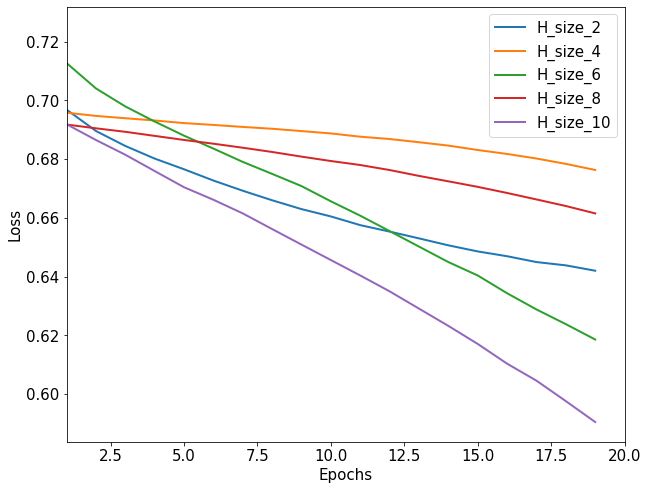

In [ ]:
H_list = [2,4,6,8,10]
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,8))
for i in range(5):
    # train_loss_list2 = [x/len(train_loader) for x in train_loss_list]
    # valid_loss_list2 = [x/len(validation_loader) for x in valid_loss_list]
    plt.plot(dict_valL[H_list[i]],label="H_size_" + str(H_list[i]),linewidth=2)
    #plt.plot(val_acc_l,c='r',label="Validation Acc",linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(1,20)
plt.legend()
plt.show()

In [ ]:
lr_list = [1e-5,1e-4,1e-3,1e-2,1e-1]
dict_trainL = {}
dict_valL = {}
dict_trainAcc={}
dict_valAcc={}

for lr in lr_list:
    D_in = 2; H = 4; D_out = 2
    model = mymodel(D_in, H, D_out)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    if torch.cuda.is_available():
        model.to('cuda')
    # Initialize steps
    step = 0
    epochs=20
    train_loss_list = []
    valid_loss_list = []
    train_acc_l = []
    val_acc_l = []
    # Iterate over number of epochs
    for e in range(epochs):
        running_loss_train = 0 
        running_loss_valid = 0
        validation_correct = 0
        validation_total = 0

        training_correct = 0
        training_total = 0  
                      
        

        # Iterate over the entire training dataset
        # one batch per iteration 
        for inputs, labels in train_loader:

            # Clear the gradients of all optimized tensors
            optimizer.zero_grad()
            if torch.cuda.is_available():
                inputs, labels = inputs.to('cuda'), labels.to('cuda')   
            else:
                inputs, labels = input_images, labels        
            # Forward pass
            model.train()
            outputs = model.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            #print(predicted,labels)
        
            #print(predicted,labels)

            training_total += labels.size(0)
            training_correct += (predicted == labels).sum().item() 
            #no_grad() prevents tracking history (and using memory)
            # with torch.no_grad(): 
                
            #     # Iterate over the entire validation dataset
            #     for input_images3, labels3 in train_loader:
                    
            #         # Enable CUDA: use GPUs for model computation
            #         if torch.cuda.is_available():
            #             input_images3, labels3 = input_images3.to('cuda'), labels3.to('cuda')
                    
            #         # Make predictions 
            #         outputs3 = model(input_images3)
            #         #print(outputs3)
            #         _, predicted3 = torch.max(outputs3.data, 1)
            #         #print(predicted2,labels2)
                    
            #         # Count total and correct predictions
      

            
            train_loss = criterion(outputs, labels)
            
            train_acc = training_correct / training_total
            # Backward pass
            train_loss.backward()
            optimizer.step()
            
            # Calculate and print running training loss
            running_loss_train += train_loss.item()   
            
        with torch.no_grad():    
                #count=0         
                # Iterate over the entire validation dataset
                for input_images2, labels2 in validation_loader:
                    
                    # Enable CUDA: use GPUs for model computation
                    #count+=1
                    #print(count)
                    if torch.cuda.is_available():
                        input_images2, labels2 = input_images2.to('cuda'), labels2.to('cuda')
                    
                    # Make predictions 
                    outputs2 = model.forward(input_images2)
                    _, predicted2 = torch.max(outputs2.data, 1)
                    #print(predicted2,labels2)
                    
                    # Count total and correct predictions
                    validation_total += labels2.size(0)
                    validation_correct += (predicted2 == labels2).sum().item()   
                    valid_loss = criterion(outputs2, labels2)
                    val_acc = validation_correct / validation_total
                    running_loss_valid += valid_loss.item()  
        
        print("Epoch: {}/{}... ".format(e+1, epochs),
              "| Train Loss: {:.4f}".format(running_loss_train/len(train_loader)),
              "| Val Loss: {:.4f}".format(running_loss_valid/len(validation_loader)),
              "| Train Acc: {:.4f}".format(train_acc),
              "| Val Acc: {:.4f}".format(val_acc))
        train_loss_list.append(running_loss_train/len(train_loader))
        valid_loss_list.append(running_loss_valid/len(validation_loader))
        train_acc_l.append(train_acc)
        val_acc_l.append(val_acc)
              
        running_loss_train = 0
        running_loss_valid = 0
    dict_trainL[lr] = train_loss_list
    dict_valL[lr] = valid_loss_list
    dict_trainAcc[lr] = train_acc
    dict_valAcc[lr] = val_acc

Epoch: 1/20...  | Train Loss: 0.6928 | Val Loss: 0.6915 | Train Acc: 0.5619 | Val Acc: 0.5638
Epoch: 2/20...  | Train Loss: 0.6927 | Val Loss: 0.6916 | Train Acc: 0.5625 | Val Acc: 0.5638
Epoch: 3/20...  | Train Loss: 0.6927 | Val Loss: 0.6919 | Train Acc: 0.5629 | Val Acc: 0.5638
Epoch: 4/20...  | Train Loss: 0.6927 | Val Loss: 0.6917 | Train Acc: 0.5638 | Val Acc: 0.5652
Epoch: 5/20...  | Train Loss: 0.6927 | Val Loss: 0.6917 | Train Acc: 0.5645 | Val Acc: 0.5638
Epoch: 6/20...  | Train Loss: 0.6927 | Val Loss: 0.6915 | Train Acc: 0.5649 | Val Acc: 0.5659
Epoch: 7/20...  | Train Loss: 0.6926 | Val Loss: 0.6916 | Train Acc: 0.5659 | Val Acc: 0.5665
Epoch: 8/20...  | Train Loss: 0.6926 | Val Loss: 0.6919 | Train Acc: 0.5671 | Val Acc: 0.5659
Epoch: 9/20...  | Train Loss: 0.6926 | Val Loss: 0.6916 | Train Acc: 0.5671 | Val Acc: 0.5692
Epoch: 10/20...  | Train Loss: 0.6926 | Val Loss: 0.6917 | Train Acc: 0.5679 | Val Acc: 0.5685
Epoch: 11/20...  | Train Loss: 0.6926 | Val Loss: 0.6918 | 

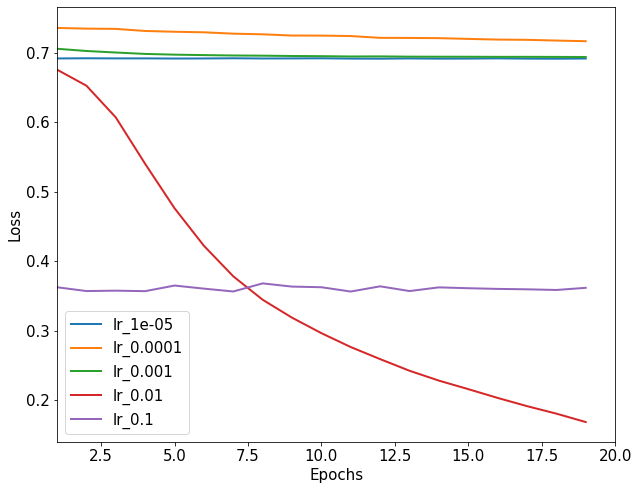

In [ ]:
lr_list = [1e-5,1e-4,1e-3,1e-2,1e-1]
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(10,8))
for i in range(5):
    # train_loss_list2 = [x/len(train_loader) for x in train_loss_list]
    # valid_loss_list2 = [x/len(validation_loader) for x in valid_loss_list]
    plt.plot(dict_valL[lr_list[i]],label="lr_" + str(lr_list[i]),linewidth=2)
    #plt.plot(val_acc_l,c='r',label="Validation Acc",linewidth=2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xlim(1,20)
plt.legend()
plt.show()


So best model is 0.01 lr with 10 hidden layers units

In [ ]:
D_in = 2; H = 10; D_out = 2
model = mymodel(D_in, H, D_out)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
if torch.cuda.is_available():
    model.to('cuda')
step = 0
epochs=100
for e in range(epochs):   
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            inputs, labels = inputs.to('cuda'), labels.to('cuda')   
        else:
            inputs, labels = input_images, labels        
        model.train()
        outputs = model.forward(inputs)
        train_loss = criterion(outputs, labels)

        train_loss.backward()
        optimizer.step()

In [ ]:
with torch.no_grad():  
      labels_list=[]
      pred_list=[] 
      inputs=[]   
      for input_images2, labels2 in test_loader:
          inputs.append(list((input_images2.cpu().detach().numpy().squeeze())))
          if torch.cuda.is_available():
              input_images2, labels2 = input_images2.to('cuda'), labels2.to('cuda')
          
          # Make predictions 
          outputs2 = model.forward(input_images2)
          _, predicted2 = torch.max(outputs2.data, 1)
          labels_list.append(labels2.cpu().detach().numpy()[0])
          pred_list.append(predicted2.cpu().detach().numpy()[0])

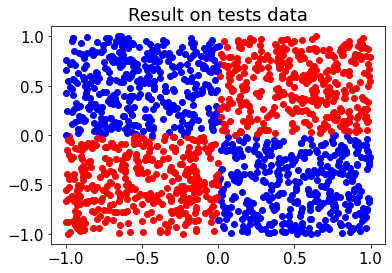

In [ ]:
# labels_list
# pred_list
# scatter_x = np.array([1,2,3,4,5])
# scatter_y = np.array([5,4,3,2,1])
x = np.array(inputs)
# group = np.array([1,3,2,1,3])
cdict = {0: 'red', 1: 'blue'}

fig, ax = plt.subplots()
for i in range(len(pred_list)):
    if (pred_list[i]==0):
          plt.scatter(x[i][0],x[i][1],color='r')
    else:
          plt.scatter(x[i][0],x[i][1],color='b')
plt.title("Result on tests data")
plt.show()